In [1]:
import timm
import torch
import torch.nn as nn

model = timm.create_model(
    model_name="swin_large_patch4_window12_384.ms_in22k", 
    pretrained=False,
    features_only=False,
    num_classes=10,
    global_pool='avg'
)

# model.load_state_dict(
#     torch.load("/Users/markun/git/rsna2024/kaggle/src/models/weights/swin_large_patch4_window12_384.ms_in22k_0.pt",
#                map_location=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")))
# for idx, (name, param) in enumerate(model.named_parameters()):
#     print(f"Parameter {idx}: Name = {name}, Value = {param}")


/Users/markun/opt/miniconda3/envs/kaggle_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
import copy
import timm
import torch.nn as nn

class SampleModel(nn.Module):

    def __init__(self):
        super(SampleModel, self).__init__()
        self.model = timm.create_model(
            model_name="swin_large_patch4_window12_384.ms_in22k", 
            pretrained=False,
            in_chans=30,
            features_only=False,
            global_pool='avg'
        )
        self.scs_head = copy.deepcopy(self.model.head)
        self.scs_head.fc = nn.Sequential(
            nn.Linear(in_features=1536, out_features=768),
            nn.GELU(),
            nn.Dropout(p=0.0),
            nn.Linear(in_features=768, out_features=384),
            nn.GELU(),
            nn.Linear(in_features=384, out_features=15),
        )

        self.nfn_head = copy.deepcopy(self.model.head)
        self.nfn_head.fc = nn.Sequential(
            nn.Linear(in_features=1536, out_features=768),
            nn.GELU(),
            nn.Dropout(p=0.0),
            nn.Linear(in_features=768, out_features=384),
            nn.GELU(),
            nn.Linear(in_features=384, out_features=30),
        )

        self.ss_head = copy.deepcopy(self.model.head)
        self.ss_head.fc = nn.Sequential(
            nn.Linear(in_features=1536, out_features=768),
            nn.GELU(),
            nn.Dropout(p=0.0),
            nn.Linear(in_features=768, out_features=384),
            nn.GELU(),
            nn.Linear(in_features=384, out_features=30),
        )
        
        self.model.head = nn.Identity()


    def forward(self, x):
        logit = self.model(x)
        scs_logit = self.scs_head(logit)
        nfn_logit = self.nfn_head(logit)
        ss_logit = self.ss_head(logit)
        return scs_logit, nfn_logit, ss_logit

model = SampleModel()
model

SampleModel(
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(30, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768, b

In [36]:
from torch import softmax


t = torch.Tensor([[-0.0017, -0.0087, -0.0104]])
t.softmax(1)

tensor([[0.3351, 0.3327, 0.3322]])

In [32]:
in_tensor = torch.rand([1,30,384,384])
in_tensor.shape

scs_out, nfn_out, ss_out = model(in_tensor)
scs_out.shape, nfn_out.shape, ss_out.shape

(torch.Size([1, 15]), torch.Size([1, 30]), torch.Size([1, 30]))

In [13]:
from sklearn.model_selection import KFold, StratifiedGroupKFold
import pandas as pd

df = pd.read_csv('/Users/markun/git/rsna2024/data/train.csv')
df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


In [ ]:
"""
fold: 0
train_study_id: 
  - 4003253
  - 7143189
valid_study_id:
  - 4646740
  - 8785691
"""

import yaml


kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (trn_idx, val_idx) in enumerate(kf.split(df)):

    print('#'*30)
    print(f'start fold {fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))

    df_train = df.iloc[trn_idx]
    df_valid = df.iloc[val_idx]
    
    train = df_train['study_id'].tolist() 
    valid = df_valid['study_id'].tolist()  

    fold_info = {
        'fold': fold,
        'train_study_id': train,
        'valid_study_id': valid
    }

    output_yaml = f'fold_{fold}.yaml'
    with open(output_yaml, 'w') as yaml_file:
        yaml.dump(fold_info, yaml_file, default_flow_style=False)

    print(f"YAMLファイル '{output_yaml}' に書き出しました。")

In [28]:
import timm

timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

Matplotlib is building the font cache; this may take a moment.


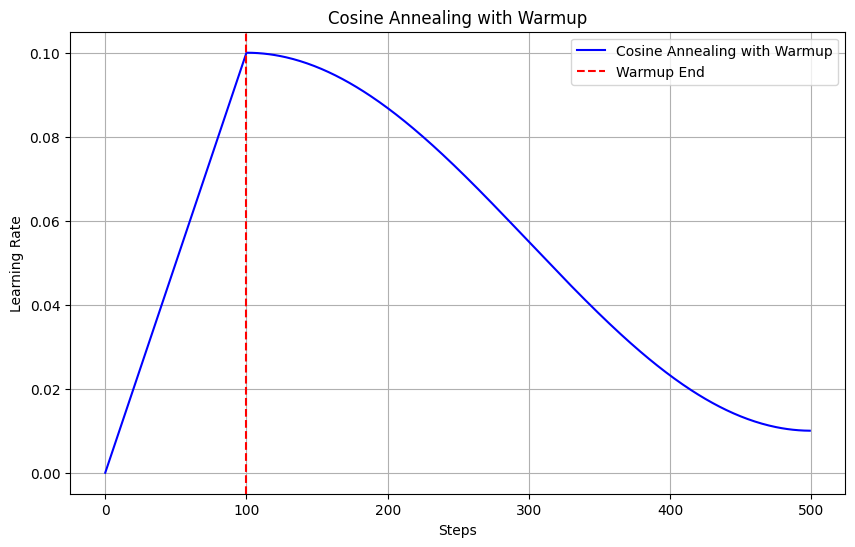

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_annealing_with_warmup(step, warmup_steps, total_steps, lr_max, lr_min):
    if step < warmup_steps:
        return lr_max * (step / warmup_steps)
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(np.pi * progress))

# パラメータ設定
lr_max = 0.1  # 初期学習率
lr_min = 0.01  # 最小学習率
warmup_steps = 100  # ウォームアップのステップ数
total_steps = 500  # 全体のステップ数

# 学習率の計算とプロットの準備
steps = np.arange(total_steps)
lrs = [cosine_annealing_with_warmup(step, warmup_steps, total_steps, lr_max, lr_min) for step in steps]

# プロット
plt.figure(figsize=(10, 6))
plt.plot(steps, lrs, label='Cosine Annealing with Warmup', color='b')
plt.axvline(x=warmup_steps, color='r', linestyle='--', label='Warmup End')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Cosine Annealing with Warmup')
plt.legend()
plt.grid(True)
plt.show()


In [26]:

import torch
import torch.nn as nn
import timm

from torchvision import models


class RSNA2024_ViT_HipOA(nn.Module):

    def __init__(
            self,
    ) -> None:
        super(RSNA2024_ViT_HipOA, self).__init__()
        self.model = models.vit_b_16()
        self.spine_classifier = [
            nn.Linear(in_features=768,
                      out_features=384,
                      bias=True),
            nn.Linear(in_features=384,
                      out_features=75)
        ]
        self.init_params()
        self.model.heads = nn.Sequential(*self.spine_classifier)
    

    def init_params(self) -> None:
        self.init_final_layer()
        self.load_pretrained_weight()
        self.change_first_layer()
        self.set_dropout_rate()

    def change_first_layer(self) -> None:
        self.model.conv_proj = nn.Conv2d(
            30, 
            768, 
            kernel_size=(16, 16), 
            stride=(16, 16)
        )
        param = self.model.state_dict()
        param['conv_proj.weight'] = nn.Parameter(
            torch.randn(768,30,16,16)
        )
    
    def init_final_layer(self) -> None:
        self.model.heads = nn.Sequential(
            nn.Linear(in_features=768,
                      out_features=7)
        )

    def set_dropout_rate(self) -> None:
        for layer in self.model.modules():
            if isinstance(layer, nn.Dropout):
                layer.p = 0.1
            else:
                pass

    def load_pretrained_weight(self) -> None:
        try:
            self.model.load_state_dict(
                torch.load(
                    f'/Users/markun/git/rsna2024/kaggle/src/models/weights/vit_weight.pth',
                    map_location=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                )
            )
            print("- Weight File Loaded !!")
        except Exception as e:
            print(e, "- Weight File Not Found !!")
    
    def forward(self, x) -> torch.Tensor:
        spine_logits = self.model(x)
        return spine_logits
model = RSNA2024_ViT_HipOA()
model

- Weight File Loaded !!


RSNA2024_ViT_HipOA(
  (model): VisionTransformer(
    (conv_proj): Conv2d(30, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.1, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.1, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln

In [27]:
for name, p in model.named_parameters():
    print(name, p.requires_grad)

model.class_token True
model.conv_proj.weight True
model.conv_proj.bias True
model.encoder.pos_embedding True
model.encoder.layers.encoder_layer_0.ln_1.weight True
model.encoder.layers.encoder_layer_0.ln_1.bias True
model.encoder.layers.encoder_layer_0.self_attention.in_proj_weight True
model.encoder.layers.encoder_layer_0.self_attention.in_proj_bias True
model.encoder.layers.encoder_layer_0.self_attention.out_proj.weight True
model.encoder.layers.encoder_layer_0.self_attention.out_proj.bias True
model.encoder.layers.encoder_layer_0.ln_2.weight True
model.encoder.layers.encoder_layer_0.ln_2.bias True
model.encoder.layers.encoder_layer_0.mlp.0.weight True
model.encoder.layers.encoder_layer_0.mlp.0.bias True
model.encoder.layers.encoder_layer_0.mlp.3.weight True
model.encoder.layers.encoder_layer_0.mlp.3.bias True
model.encoder.layers.encoder_layer_1.ln_1.weight True
model.encoder.layers.encoder_layer_1.ln_1.bias True
model.encoder.layers.encoder_layer_1.self_attention.in_proj_weight Tru